# Run C DNS Output Selection

For the bursting run C, we want to initialize CE2 from both high and low states. Here, we choose which snapshots to use.

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import numpy as np
import h5py

In [3]:
plt.style.use('prl')

In [4]:
filebase = 'scratch/busse_annulus_ra8.00e+07_beta5.00e+05_C0.00e+00_Pr1.00e+00_filter5.00e-01_nx512_ny256_CFL_xy/'

ts_filen = filebase + 'timeseries/timeseries_s1.h5'
sn_filen = filebase + 'snapshots.h5'

In [5]:
ts = h5py.File(ts_filen,'r')
sn = h5py.File(sn_filen,'r')

In [6]:
ts_time = ts['scales/sim_time'][:]
ts_ekin = ts['tasks/Ekin'][:,0]
ts_ezonal = ts['tasks/E_zonal'][:,0]
ts_enz = ts_ekin-ts_ezonal

In [7]:
an_mask = (ts_time > 1.5)

In [8]:
max_idx = np.argmax(ts_enz[an_mask])
min_idx = np.argmin(ts_ekin[an_mask])

tmin = ts_time[an_mask][min_idx]
tmax = ts_time[an_mask][max_idx]

In [9]:
tmin

1.8220006765925754

In [10]:
t_quiet = 1.69
t_minshear = 1.702
t_maxshear = 1.672
idx_burst = int(1000*tmax)
idx_quiet = int(1000*t_quiet)
idx_minshear = int(1000*t_minshear)
idx_maxshear = int(1000*t_maxshear)

In [11]:
print("Quiet index: {}; Burst index: {}".format(idx_quiet, idx_burst))

Quiet index: 1690; Burst index: 1665


Let's make a simple model for the shear at a given time:

$$\frac{\partial \left< u \right>_x}{\partial y} \approx \frac{\left< u \right>_x(1) - \left< u \right>_x(0)}{\Delta y}$$

In [12]:
def calc_shear(u_x):
    u_x_mean = u_x.mean(axis=1)
    shear = (u_x_mean[:,-1]- u_x_mean[:,0])
    
    return shear

In [13]:
shear_vs_t = calc_shear(sn['tasks/u_x'][:])

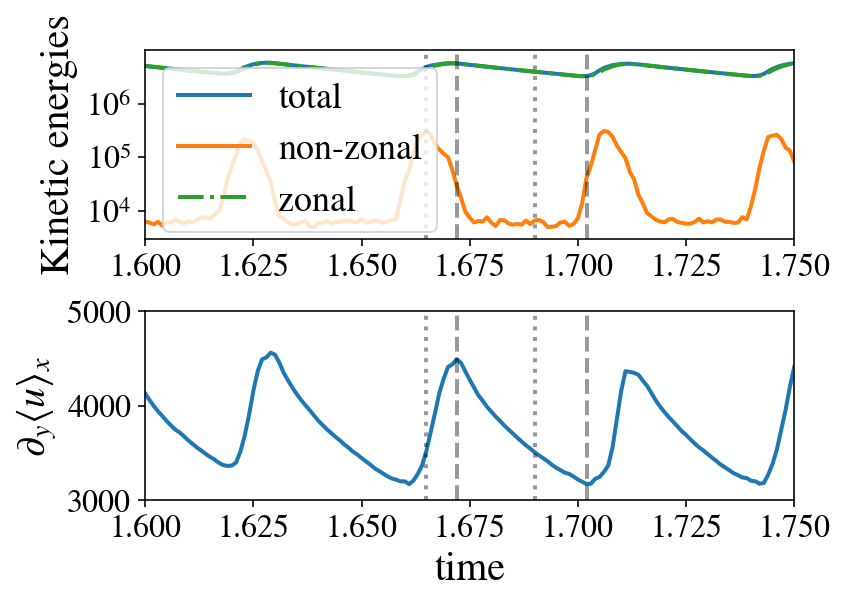

In [27]:
plt.subplot(211)
plt.semilogy(ts_time, ts_ekin, label='total')
plt.semilogy(ts_time, ts_enz, label='non-zonal')
plt.semilogy(ts_time,ts_ezonal, '-.', label='zonal')
plt.legend()
plt.axvline(tmax, ls='dotted', color='k',alpha=0.4)
plt.axvline(t_minshear, ls='--',color='k',alpha=0.4)
plt.axvline(t_maxshear, ls='--',color='k',alpha=0.4)

plt.axvline(t_quiet, ls='dotted', color='k',alpha=0.4)
plt.ylabel("Kinetic energies")
plt.xlim(1.6,1.75)
plt.ylim(3e3,1e7)
plt.yticks([1e4,1e5,1e6])
plt.subplot(212)
plt.plot(ts_time, shear_vs_t)
plt.axvline(tmax, ls='dotted', color='k',alpha=0.4)
plt.axvline(t_maxshear, ls='--',color='k',alpha=0.4)

plt.axvline(t_minshear, ls='--',color='k',alpha=0.4)
plt.axvline(t_quiet, ls='dotted', color='k',alpha=0.4)
plt.xlabel("time")
plt.ylabel(r"$\partial_y \left<u\right>_x$")
plt.xlim(1.6,1.75)
plt.ylim(3000,5000)
plt.tight_layout()

Note in the above plot a very interesting thing: the dashed lines show the peak of convective (non-zonal) kinetic energy and a representative minimim convective kineitic energy. The lower panel shows that the shear is nearly identical at those two times.

The dashed lines, on the other hand, show the times of maximum and minimum shear. Interestingly, looking at the upper panel, we see that these have *nearly the same convective kinetic energy*.

In [15]:
sn_time= sn['scales/sim_time'][:]

In [16]:
def value_nearest(array, value):
    idx = np.abs((array - value)).argmin()
    
    return idx, array[idx]

In [17]:
value_nearest(sn_time,1.7850002)

(1785, 1.7850001962049418)

In [18]:
value_nearest(sn_time,1.8220006765925754)

(1822, 1.8220006765925754)

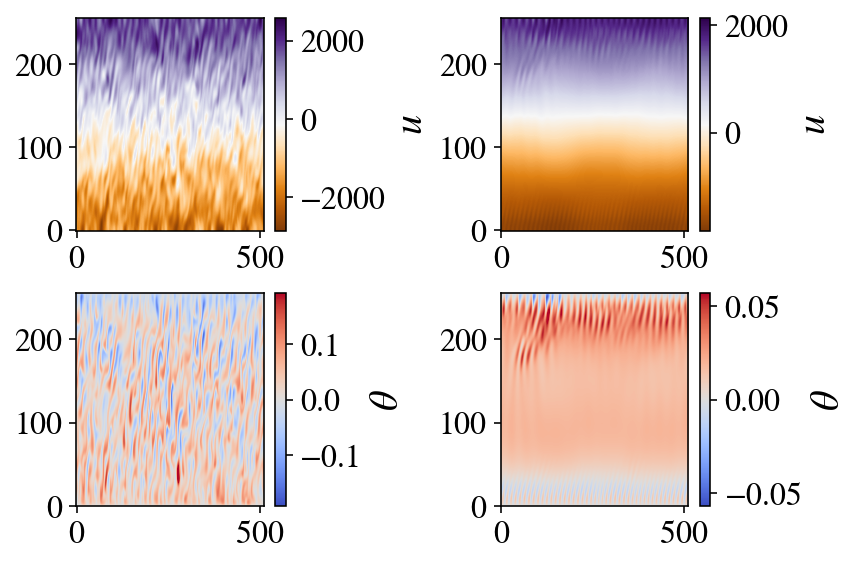

In [19]:
plt.subplot(221)
plt.imshow(sn['tasks/u_x'][idx_burst,:,:].T, origin='lower',cmap='PuOr',aspect='auto')
plt.colorbar(label=r'$u$')
plt.subplot(222)
plt.imshow(sn['tasks/u_x'][idx_quiet,:,:].T, origin='lower',cmap='PuOr',aspect='auto')
plt.colorbar(label=r'$u$')

plt.subplot(223)
plt.imshow(sn['tasks/theta'][idx_burst,:,:].T, origin='lower',cmap='coolwarm',vmin=-0.192,vmax=0.192,aspect='auto')
plt.colorbar(label=r'$\theta$')
plt.subplot(224)
plt.imshow(sn['tasks/theta'][idx_quiet,:,:].T, origin='lower',cmap='coolwarm',vmin=-0.0568,vmax=0.0568,aspect='auto')
plt.colorbar(label=r'$\theta$')
plt.tight_layout()


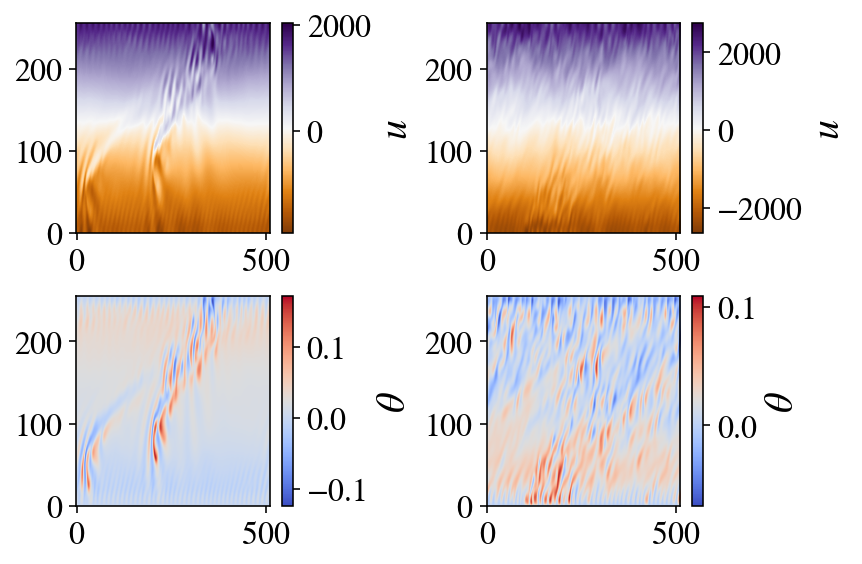

In [20]:
plt.subplot(221)
plt.imshow(sn['tasks/u_x'][idx_minshear,:,:].T, origin='lower',cmap='PuOr',aspect='auto')
plt.colorbar(label=r'$u$')
plt.subplot(222)
plt.imshow(sn['tasks/u_x'][idx_maxshear,:,:].T, origin='lower',cmap='PuOr',aspect='auto')
plt.colorbar(label=r'$u$')

plt.subplot(223)
plt.imshow(sn['tasks/theta'][idx_minshear,:,:].T, origin='lower',cmap='coolwarm',aspect='auto')
plt.colorbar(label=r'$\theta$')
plt.subplot(224)
plt.imshow(sn['tasks/theta'][idx_maxshear,:,:].T, origin='lower',cmap='coolwarm',aspect='auto')
plt.colorbar(label=r'$\theta$')
plt.tight_layout()

Interestingly, the range of shear is quite small throughout the relaxation oscillation!

The shaded region shows $\left< u \right>_x$ from the minimum to maximum shear values over a relaxation oscillation, while the 'burst' and 'quiet' phases show the two solutions we will feed into CE2. Note that they have almost identical shear!

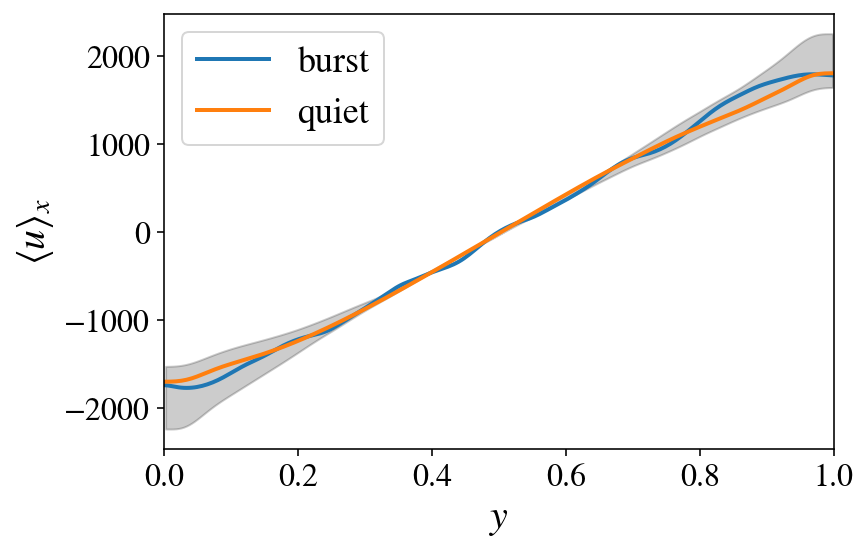

In [21]:
plt.plot(sn['scales/y/1.0'][:],sn['tasks/u_x'][idx_burst,:,:].mean(axis=0),label='burst')
plt.plot(sn['scales/y/1.0'][:],sn['tasks/u_x'][idx_quiet,:,:].mean(axis=0), label='quiet')
plt.fill_between(sn['scales/y/1.0'][:],sn['tasks/u_x'][idx_minshear,:,:].mean(axis=0),sn['tasks/u_x'][idx_maxshear,:,:].mean(axis=0), color='k',alpha=0.2)
plt.xlabel(r"$y$")
plt.ylabel(r"$\left< u \right>_x$")
plt.xlim(0,1)
plt.legend()

In [22]:
test = np.zeros((100,23))

In [23]:
test[1,:].shape

(23,)

In [24]:
test[slice(1,1),slice(None)].shape

(0, 23)

In [25]:
sel = 1

In [26]:
t_sl = (None, 1)
test[sel,slice(None)].shape

(23,)